In [1]:
from DeepMRI import DeepMRI
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import SegAN_IO_arch as SegAN_IO

### Evaluating SeganIO on every dataset modality
This function allows to evaluate a model on a desired dataset. If you are using anything different than SegAN_IO, please import it as "arch"

In [8]:
def evaluate_on(modelname_to_load, checkpoint_to_load, target_datasets, target_mri_types, output_csv, arch=SegAN_IO):
    '''
    Evaluates a given model on a source dataset (the one it has been used for training) and then on a target dataset.
    :param modelname_to_load: The name of the model to load
    :param checkpoint_to_load: Filename of the checkpoint to load. Can be 'last'.
    :param target_dataset: List of dataset names on which evaluate the model
    :param target_mri_type: List of MRI types (as lists) on which evaluate the model.
    :param output_csv: Where to store the results. The csv will contain one row for each evaluated dataset
    '''

    gan = DeepMRI(batch_size=64, size=160, mri_channels=len(target_mri_types[0]), model_name=modelname_to_load)
    gan.build_model(load_model=gan.save_path+checkpoint_to_load, seed=1234567890, arch=arch)
    
    eval_log = pd.DataFrame()
    
    for target_dataset, target_mri_type in zip(target_datasets, target_mri_types):
        print("\nEvaluating on {}-{}".format(target_dataset, ','.join(target_mri_type)))
        gan.load_dataset(dataset=target_dataset, mri_types=target_mri_type)
        log = gan.evaluate(output_csv,'testing')
        log['Target Dataset'] = target_dataset
        log['Target Modality'] = ' '.join([t.replace('MR_', '') for t in target_mri_type])
        
        mean = pd.DataFrame()
        for g, group in log.groupby(['model', 'run', 'Target Dataset', 'Target Modality']):
            m = group.mean(axis=0).to_frame().transpose()
            for c in group.columns:
                if c not in m.columns:
                    m[c] = group.iloc[0][c]
            m = m.drop(columns=['slice', 'loss_d', 'loss_g'])    
            mean = mean.append(m, ignore_index=True)
        eval_log = eval_log.append(mean, ignore_index=True)
        
    eval_log.to_csv(output_csv)
    print("Output saved to {}".format(output_csv))
    
def plot_csv(output_csv, metrics=['dice_score', 'precision', 'sensitivity']):
    log = pd.read_csv(output_csv, usecols=metrics + ['dataset', 'mri_types'])
    log = log.set_index(['dataset', 'mri_types'])
    stacked = log.stack()
    stacked = stacked.rename_axis(index=['dataset', 'modality', 'metric'])
    logdata = stacked.reset_index()
    logdata = logdata.rename(columns={0:'value'})
    plt.figure(figsize=(30,20))
    sb.catplot(data=logdata, col='metric', col_wrap=3, hue='dataset', x='modality', y="value", kind='bar', sharex=False)
    plt.show()
    
def compare_models(output_csv, model_names, source_ds, source_mod, show_relative_performances, metrics=['dice_score', 'precision', 'sensitivity'], save_path=None):
    df = None
    val_column_name = 'rel_performance' if show_relative_performances else 'value'
    for csv, model_name, src_ds, src_mod in zip(output_csv, model_names, source_ds, source_mod):
        log = pd.read_csv(csv, usecols=metrics + ['Target Dataset', 'Target Modality'])
        log['model'] = model_name
        log = log.set_index(['model', 'Target Dataset', 'Target Modality'])
        if show_relative_performances:
            log = log / log.loc[model_name].loc[src_ds].loc[src_mod]
        stacked = log.stack()
        stacked = stacked.rename_axis(index=['model','Target Dataset', 'Target Modality', 'metric'])

        logdata = stacked.reset_index()
        logdata = logdata.rename(columns={0:val_column_name})
        # Merge dataset and modality for visualization
        logdata['dataset_and_modality'] = logdata['Target Dataset']+ '_' +logdata['Target Modality']
        
        if df is None:
            df = logdata
        else:
            df = df.append(logdata, ignore_index=True)
    sb.set_style("whitegrid")
    sb.set_context("paper", font_scale=2)
    
    if len(metrics)==1:
        # This is for showing the metric name on y axis
        metric_name = metrics[0].replace('_', ' ')
        temp = df.rename(columns={'value': metric_name})
        plot = sb.catplot(data=temp, x='Target Modality', y=metric_name, col='model', kind='bar', col_wrap=2, sharex=False)
    else:
        plot = sb.catplot(data=df, x='Target Modality', y=val_column_name, row='metric', col='model', kind='bar')
    #plot.set_xticklabels(rotation = 90, ha="right")
    plot.add_legend()
    if save_path:
        plt.savefig(save_path)
    plt.show()
    return df

target_datasets = ['brats', 'brats', 'brats', 'brats']
target_mri_types = [['MR_T1'],['MR_T1c'],['MR_T2'], ['MR_Flair']]

#### Evaluating models trained on BRATS

In [ ]:
evaluate_on(modelname_to_load = "Segan_IO_TF2_brats_on_T1", 
            checkpoint_to_load = 'best_dice_score_861-45', 
            target_datasets = target_datasets, 
            target_mri_types = target_mri_types, 
            output_csv = 'results/transfer_baselines/Segan_IO_TF2_brats_on_T1_base_performances.csv')


evaluate_on(modelname_to_load = "Segan_IO_TF2_brats_on_T1c", 
            checkpoint_to_load = 'best_dice_score_1011-48', 
            target_datasets = target_datasets, 
            target_mri_types = target_mri_types, 
            output_csv = 'results/transfer_baselines/Segan_IO_TF2_brats_on_T1c_base_performances.csv')


evaluate_on(modelname_to_load = "Segan_IO_TF2_brats_on_T2", 
            checkpoint_to_load = 'best_dice_score_182-25', 
            target_datasets = target_datasets, 
            target_mri_types = target_mri_types, 
            output_csv = 'results/transfer_baselines/Segan_IO_TF2_brats_on_T2_base_performances.csv')

evaluate_on(modelname_to_load = "Segan_IO_TF2_brats_on_FLAIR", 
            checkpoint_to_load = 'best_dice_score_168-29', 
            target_datasets = target_datasets, 
            target_mri_types = target_mri_types, 
            output_csv = 'results/transfer_baselines/Segan_IO_TF2_brats_on_FLAIR_base_performances.csv')


#### Visualize performances of every model against every dataset
output_csv contains the list of csv generated in the previous secion. Fill source_ds and source_mod with the corresponding dataset and modality the model has been trained on.

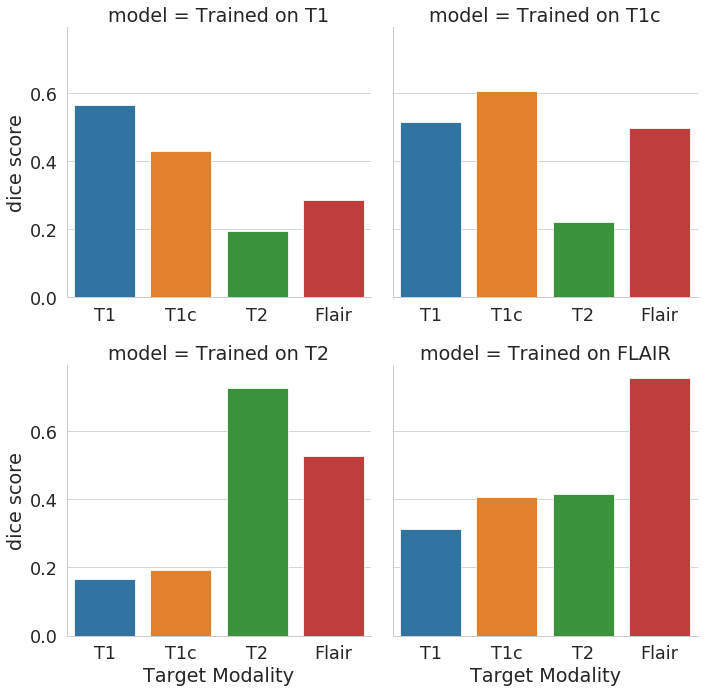

In [11]:
#Show base models
output_csv = ["results/transfer_baselines/Segan_IO_TF2_brats_on_T1_base_performances.csv", 
              "results/transfer_baselines/Segan_IO_TF2_brats_on_T1c_base_performances.csv", 
              "results/transfer_baselines/Segan_IO_TF2_brats_on_T2_base_performances.csv",
              "results/transfer_baselines/Segan_IO_TF2_brats_on_FLAIR_base_performances.csv"]
model_names = ["Trained on T1",
               "Trained on T1c",
               "Trained on T2",
               "Trained on FLAIR"]
source_ds = ['brats', 'brats', 'brats', 'brats']
source_mod = ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair']
performances = compare_models(output_csv, model_names, source_ds, source_mod,metrics=['dice_score'], show_relative_performances=False, save_path='results/transfer_baselines/base_performances.png')

In [29]:
performances

,model,dataset,modality,metric,dice score,dataset_and_modality
0,SegAN_IO-T1,brats,MR_T1,dice_score,0.561918,brats_MR_T1
1,SegAN_IO-T1,brats,MR_T1c,dice_score,0.403286,brats_MR_T1c
2,SegAN_IO-T1,brats,MR_T2,dice_score,0.118884,brats_MR_T2
3,SegAN_IO-T1,brats,MR_Flair,dice_score,0.122261,brats_MR_Flair
4,SegAN_IO-T1c,brats,MR_T1,dice_score,0.480998,brats_MR_T1
5,SegAN_IO-T1c,brats,MR_T1c,dice_score,0.632689,brats_MR_T1c
6,SegAN_IO-T1c,brats,MR_T2,dice_score,0.196240,brats_MR_T2
7,SegAN_IO-T1c,brats,MR_Flair,dice_score,0.409641,brats_MR_Flair
8,SegAN_IO-T2,brats,MR_T1,dice_score,0.141650,brats_MR_T1
9,SegAN_IO-T2,brats,MR_T1c,dice_score,0.152520,brats_MR_T1c
